# Fast GRF Graph Kernel with Train/Val/Test

Clean implementation of Fast Graph Random Features kernel with proper evaluation framework.

### Preprocessing

In [34]:

%reload_ext autoreload
%autoreload 2
import torch
import gpytorch
from gpytorch import settings as gsettings
from linear_operator import settings
from linear_operator.utils import linear_cg
from linear_operator.operators import IdentityLinearOperator
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import pandas as pd
import sys
sys.path.append('/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs')
from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel
from efficient_graph_gp_sparse.preprocessor import GraphPreprocessor

# Set seeds for reproducibility
# np.random.seed(42)
# torch.manual_seed(42)

In [ ]:
# =============================================================================
# EXPERIMENT CONFIGURATION
# =============================================================================

settings.verbose_linalg._default = True
settings._fast_covar_root_decomposition._default = False

# GPyTorch settings
gsettings.max_cholesky_size._global_value = 0
gsettings.cg_tolerance._global_value = 1e-2
gsettings.max_lanczos_quadrature_iterations._global_value = 53
gsettings.num_trace_samples._global_value = 64
# gpytorch.settings.max_eager_kernel_size = 0

# Dataset parameters
N_NODES = 100               # Number of nodes in the ring graph
NOISE_STD = 0.1            # Noise standard deviation
SPLITS = [0.6, 0.2, 0.2]   # Train/val/test split ratios

# Kernel parameters
WALKS_PER_NODE = 1000      # Number of random walks per node
P_HALT = 0.1               # Halt probability for random walks
MAX_WALK_LENGTH = 3        # Maximum walk length
RANDOM_WALK_SEED = 42      # Seed for random walk generation

# Training parameters
LEARNING_RATE = 0.1        # Adam optimizer learning rate
MAX_ITERATIONS = 100       # Maximum training iterations
PATIENCE = 20              # Early stopping patience
PRINT_INTERVAL = 20        # Progress printing interval

# Inference parameters
PATHWISE_SAMPLES = 64      # Number of samples for pathwise inference

In [36]:
# Data generation and splits
def create_ring_dataset(n_nodes=50, noise_std=0.1, splits=[0.6, 0.2, 0.2]):
    """Create ring graph dataset with train/val/test splits"""
    # Create graph
    G = nx.cycle_graph(n_nodes)
    A = nx.adjacency_matrix(G).tocsr()
    
    # Generate smooth function on ring
    angles = np.linspace(0, 2*np.pi, n_nodes, endpoint=False)
    y_true = 2*np.sin(2*angles) + 0.5*np.cos(4*angles) + 0.3*np.sin(angles)
    y_observed = y_true + np.random.normal(0, noise_std, n_nodes)
    
    # Create splits
    indices = np.arange(n_nodes)
    train_size = int(splits[0] * n_nodes)
    val_size = int(splits[1] * n_nodes)
    
    train_idx = np.random.choice(indices, train_size, replace=False)
    remaining = np.setdiff1d(indices, train_idx)
    val_idx = np.random.choice(remaining, val_size, replace=False)
    test_idx = np.setdiff1d(remaining, val_idx)
    
    # Convert to tensors
    data = {
        'X_train': torch.tensor(train_idx, dtype=torch.float32).unsqueeze(1),
        'y_train': torch.tensor(y_observed[train_idx], dtype=torch.float32),
        'X_val': torch.tensor(val_idx, dtype=torch.float32).unsqueeze(1),
        'y_val': torch.tensor(y_observed[val_idx], dtype=torch.float32),
        'X_test': torch.tensor(test_idx, dtype=torch.float32).unsqueeze(1),
        'y_test': torch.tensor(y_observed[test_idx], dtype=torch.float32),
        'A': A, 'G': G, 'y_true': y_true, 'y_observed': y_observed,
        'train_idx': train_idx, 'val_idx': val_idx, 'test_idx': test_idx
    }
    
    print(f"Dataset: {n_nodes} nodes, splits: {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")
    return data

# Create dataset using configured parameters
data = create_ring_dataset(n_nodes=N_NODES, noise_std=NOISE_STD, splits=SPLITS)

Dataset: 100 nodes, splits: 60/20/20


In [37]:
# precompute the step matrices for the kernel

pp = GraphPreprocessor(
    adjacency_matrix=data['A'],
    walks_per_node=WALKS_PER_NODE,
    p_halt=P_HALT,
    max_walk_length=MAX_WALK_LENGTH,
    random_walk_seed=RANDOM_WALK_SEED,
    load_from_disk=False)

step_matrices_torch = pp.preprocess_graph()

Random walks: 100%|██████████| 100/100 [00:01<00:00, 58.78it/s]


### Model Definition

In [38]:
# Model definition
class GraphGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood, step_matrices_torch):
        super().__init__(x_train, y_train, likelihood)
        self.x_train = x_train
        self.y_train = y_train
        self.mean_module = gpytorch.means.ZeroMean()
        self.step_matrices_torch = step_matrices_torch
        self.covar_module = SparseGRFKernel( 
            max_walk_length=MAX_WALK_LENGTH, 
            step_matrices_torch=self.step_matrices_torch
        )
        self.num_nodes = step_matrices_torch[0].shape[0]
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, x_test, n_samples=64):
        """
        Batch pathwise conditioning sampling.
        
        f_test_posterior = f_test_prior + K_test_train @ v
        v = (K_train_train + noise_variance*I)^{-1} @ (y_train - (f_train_prior + eps))
        f_test_prior and f_train_prior are jointly sampled from N(0, K)
        eps ~ N(0, noise_variance*I)
        
        Args:
            x_test (torch.Tensor): Test input locations (shape: [n_test, 1])
            n_samples (int): Number of samples to generate from the posterior
        """    
        
        num_train = self.x_train.shape[0]
        train_indices = self.x_train.int().flatten()
        test_indices = x_test.int().flatten()
        
        # Get feature matrix and extract submatrices
        phi = self.covar_module._get_feature_matrix()
        phi_train = phi[train_indices, :]
        phi_test = phi[test_indices, :]
        
        # Precompute covariance matrices
        K_train_train = phi_train @ phi_train.T
        K_test_train = phi_test @ phi_train.T
        
        # Noise parameters
        noise_variance = self.likelihood.noise.item()
        noise_std = np.sqrt(noise_variance)
        A = K_train_train + noise_variance * IdentityLinearOperator(num_train, device=x_test.device)
        
        # Generate batch random samples
        eps1_batch = torch.randn(n_samples, self.num_nodes, device=x_test.device)
        eps2_batch = noise_std * torch.randn(n_samples, num_train, device=x_test.device)
        
        # Batch compute prior samples
        f_test_prior_batch = eps1_batch @ phi_test.T
        f_train_prior_batch = eps1_batch @ phi_train.T
        
        # Batch compute RHS vectors
        b_batch = self.y_train.unsqueeze(0) - (f_train_prior_batch + eps2_batch)
        
        # Batched CG solve: v_batch = (K_tt + σ² I)^{-1} b_batch
        
        print(f"A.shape: {A.shape}, b_batch.shape: {b_batch.shape}")
        v_batch = linear_cg(
            matmul_closure=A._matmul,
            rhs=b_batch.T,
            tolerance=settings.cg_tolerance.value()
        )
        
        # Posterior samples at test inputs
        f_test_posterior_batch = f_test_prior_batch + (K_test_train @ v_batch).T  # [n_samples, n_test]

        return f_test_posterior_batch

# Initialize model using configured parameters
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GraphGPModel(data['X_train'], data['y_train'], likelihood, step_matrices_torch)

### Training Loop

In [39]:
# Training with validation monitoring
def train_model(model, likelihood, data, lr=0.01, max_iter=100, patience=20):
    """Train model with early stopping"""
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    train_losses, val_losses, val_rmses = [], [], []
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    
    for i in range(max_iter):
        # Training step
        optimizer.zero_grad()
        train_output = model(data['X_train'])
        train_loss = -mll(train_output, data['y_train'])
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        
        # Validation step
        model.eval()
        likelihood.eval()
        with torch.no_grad():
            val_output = model(data['X_val'])
            val_loss = -mll(val_output, data['y_val'])
            val_pred = likelihood(val_output)
            val_rmse = np.sqrt(mean_squared_error(data['y_val'], val_pred.mean))
            
        val_losses.append(val_loss.item())
        val_rmses.append(val_rmse)
        
        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_state = {'model': model.state_dict(), 'likelihood': likelihood.state_dict()}
            patience_counter = 0
        else:
            patience_counter += 1
            
        if i % PRINT_INTERVAL == 0:
            print(f'Iter {i+1}: Train Loss={train_loss:.3f}, Val Loss={val_loss:.3f}, modulator={model.covar_module.modulator_vector.detach().numpy()}, noise={likelihood.noise.item():.4f}')
            
        if patience_counter >= patience:
            print(f'Early stopping at iteration {i+1}')
            break
        
        model.train()
        likelihood.train()
    
    # Load best model
    if best_state:
        model.load_state_dict(best_state['model'])
        likelihood.load_state_dict(best_state['likelihood'])
        
    return train_losses, val_losses, val_rmses

# Train model using configured parameters
train_losses, val_losses, val_rmses = train_model(
    model, likelihood, data, 
    lr=LEARNING_RATE, 
    max_iter=MAX_ITERATIONS, 
    patience=PATIENCE
)

LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 32, 32]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 1]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 1]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 20]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([20, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([20, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 20, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 29, 29]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 1]) RHS for 1000 iterations (

Iter 1: Train Loss=2.396, Val Loss=3.314, modulator=[-0.5547497 -1.0491956 -0.7631916], noise=0.7445


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 15, 15]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 1]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 1]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 20]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([20, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([20, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 10, 10]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 12, 12]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 1]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 1]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 20]) RHS for 1000 iterations (t

Iter 21: Train Loss=1.726, Val Loss=1.574, modulator=[-1.72952     0.34188086  0.4718668 ], noise=1.5336


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 20]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([20, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([20, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 11, 11]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 13, 13]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 1]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 1]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 20]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([20, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([20, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a

Iter 41: Train Loss=1.506, Val Loss=1.077, modulator=[-1.7839427  0.8682132  0.0719158], noise=0.3939


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([20, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([20, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 15, 15]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 20, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 1]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 1]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 20]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([20, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([20, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 15, 15]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 65]) RHS for 1000 iterations 

Iter 61: Train Loss=1.136, Val Loss=0.397, modulator=[-1.9198765  2.0657837 -0.5478262], noise=0.0498


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 53, 53]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 1]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 1]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 20]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([20, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([20, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 20, 20]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 65]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 65]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([64, 53, 53]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 1]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 1]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 20]) RHS for 1000 iterations (t

Iter 81: Train Loss=1.085, Val Loss=1.050, modulator=[-2.3690104  2.7731607 -0.8079204], noise=0.0132
Early stopping at iteration 83


### Inference

In [40]:
# Evaluation function using pathwise sampling
def evaluate_model(model, likelihood, X, y, split_name, n_samples=100):
    """Evaluate model using pathwise sampling prediction"""
    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        # Get posterior samples using pathwise conditioning
        samples = model.predict(X, n_samples=n_samples)  # Shape: (n_samples, n_points)
        
        # Compute statistics from samples
        mean_pred = samples.mean(dim=0)
        std_pred = samples.std(dim=0)
        
        # Compute 95% confidence intervals using quantiles
        lower_ci = torch.quantile(samples, 0.025, dim=0)
        upper_ci = torch.quantile(samples, 0.975, dim=0)
    
    # Convert to numpy for metrics calculation
    y_np = y.cpu().numpy()
    mean_pred_np = mean_pred.cpu().numpy()
    std_pred_np = std_pred.cpu().numpy()
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_np, mean_pred_np))
    mae = np.mean(np.abs(y_np - mean_pred_np))
    
    # Coverage using empirical quantiles (more accurate)
    coverage = torch.mean(((y >= lower_ci) & (y <= upper_ci)).float()).item()
    
    results = {
        'rmse': rmse, 
        'mae': mae, 
        'coverage': coverage * 100,
        'predictions': mean_pred, 
        'std': std_pred,
        'samples': samples,
        'lower_ci': lower_ci,
        'upper_ci': upper_ci
    }
    
    print(f"{split_name}: RMSE={rmse:.4f}, MAE={mae:.4f}, Coverage={coverage*100:.1f}%")
    return results

# Evaluate all splits using pathwise sampling
print("=== PATHWISE SAMPLING EVALUATION ===")
train_results = evaluate_model(model, likelihood, data['X_train'], data['y_train'], "Train", n_samples=PATHWISE_SAMPLES)
val_results = evaluate_model(model, likelihood, data['X_val'], data['y_val'], "Val", n_samples=PATHWISE_SAMPLES)
test_results = evaluate_model(model, likelihood, data['X_test'], data['y_test'], "Test", n_samples=PATHWISE_SAMPLES)

# Predict on all nodes for visualization
print("\n=== GENERATING FULL GRAPH PREDICTIONS ===")
with torch.no_grad():
    X_all = torch.arange(len(data['y_true']), dtype=torch.float32).unsqueeze(1)
    all_samples = model.predict(X_all, n_samples=PATHWISE_SAMPLES)
    
    all_mean = all_samples.mean(dim=0)
    all_std = all_samples.std(dim=0)

print(f"Generated predictions for all {len(data['y_true'])} nodes")

=== PATHWISE SAMPLING EVALUATION ===


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 10000]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 10000]).


A.shape: torch.Size([60, 60]), b_batch.shape: torch.Size([10000, 60])


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 10000]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 10000]).


Train: RMSE=0.0359, MAE=0.0264, Coverage=100.0%
A.shape: torch.Size([60, 60]), b_batch.shape: torch.Size([10000, 60])


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 10000]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 10000]).


Val: RMSE=0.5244, MAE=0.4291, Coverage=80.0%
A.shape: torch.Size([60, 60]), b_batch.shape: torch.Size([10000, 60])


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([60, 10000]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([60, 10000]).


Test: RMSE=0.4071, MAE=0.2606, Coverage=95.0%

=== GENERATING FULL GRAPH PREDICTIONS ===
A.shape: torch.Size([60, 60]), b_batch.shape: torch.Size([10000, 60])
Generated predictions for all 100 nodes


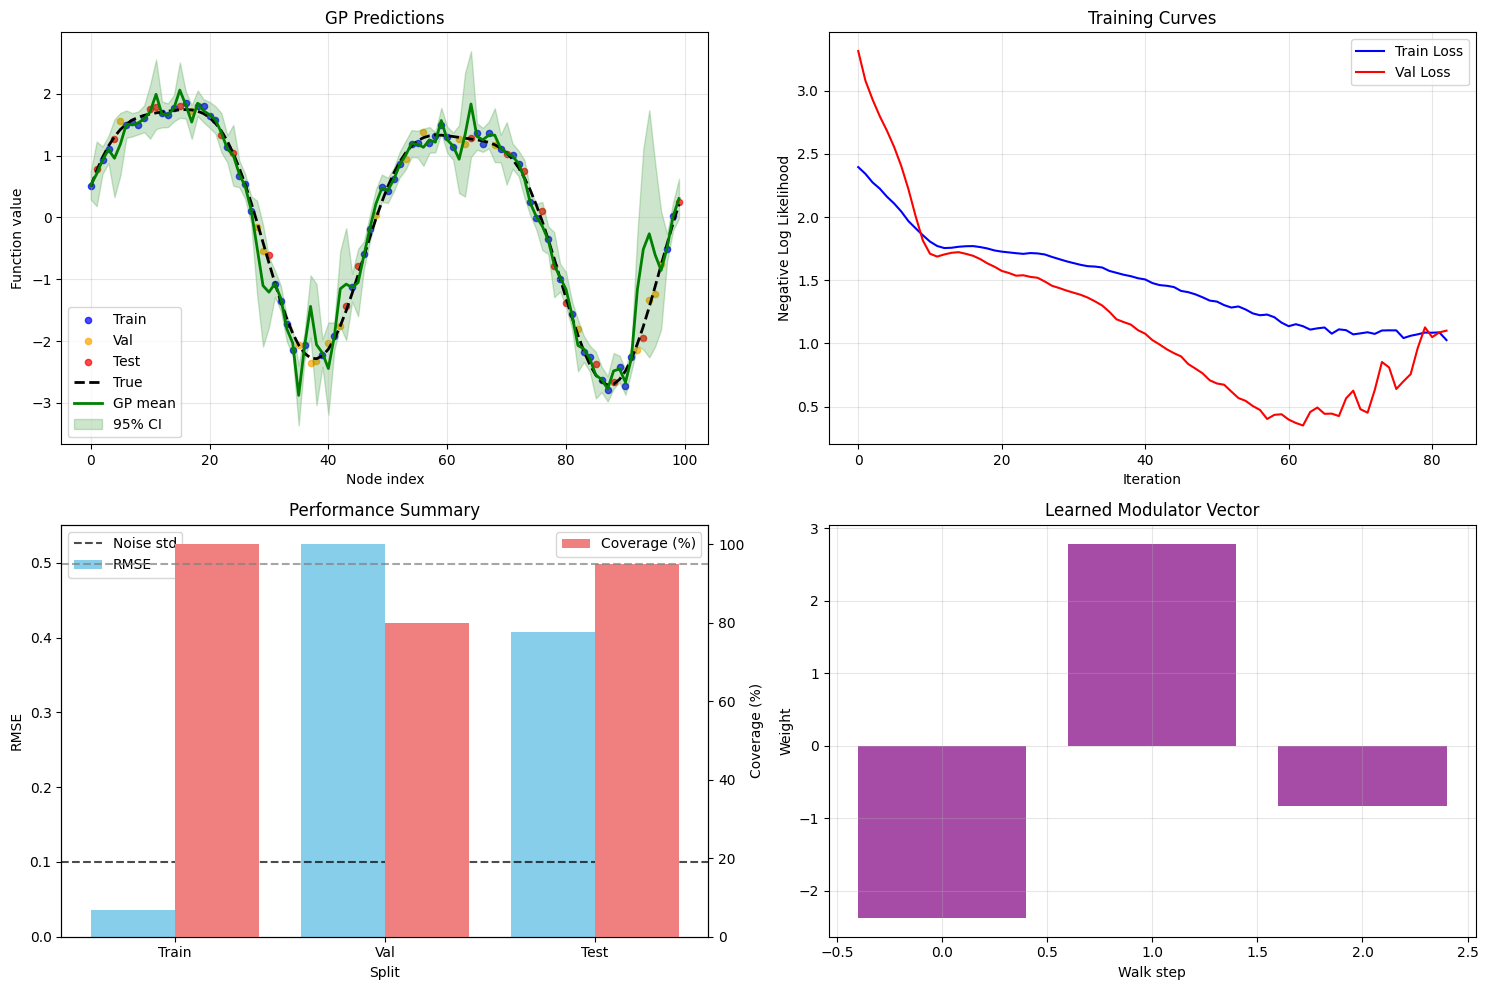

In [41]:
# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Predictions vs true function
n_nodes = len(data['y_true'])
ax1.scatter(data['train_idx'], data['y_train'], c='blue', alpha=0.7, s=20, label='Train')
ax1.scatter(data['val_idx'], data['y_val'], c='orange', alpha=0.7, s=20, label='Val')
ax1.scatter(data['test_idx'], data['y_test'], c='red', alpha=0.7, s=20, label='Test')
ax1.plot(range(n_nodes), data['y_true'], 'k--', linewidth=2, label='True')
ax1.plot(range(n_nodes), all_mean, 'g-', linewidth=2, label='GP mean')
ax1.fill_between(range(n_nodes), all_mean - 2*all_std, all_mean + 2*all_std, 
                alpha=0.2, color='green', label='95% CI')
ax1.set_xlabel('Node index')
ax1.set_ylabel('Function value')
ax1.set_title('GP Predictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Training curves
ax2.plot(train_losses, label='Train Loss', color='blue')
ax2.plot(val_losses, label='Val Loss', color='red')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Negative Log Likelihood')
ax2.set_title('Training Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Performance comparison
splits = ['Train', 'Val', 'Test']
rmses = [train_results['rmse'], val_results['rmse'], test_results['rmse']]
coverages = [train_results['coverage'], val_results['coverage'], test_results['coverage']]

x = np.arange(len(splits))
ax3_twin = ax3.twinx()
bars1 = ax3.bar(x - 0.2, rmses, 0.4, label='RMSE', color='skyblue')
bars2 = ax3_twin.bar(x + 0.2, coverages, 0.4, label='Coverage (%)', color='lightcoral')
ax3.axhline(y=0.1, color='black', linestyle='--', alpha=0.7, label='Noise std')
ax3_twin.axhline(y=95, color='gray', linestyle='--', alpha=0.7)
ax3.set_xlabel('Split')
ax3.set_ylabel('RMSE')
ax3_twin.set_ylabel('Coverage (%)')
ax3.set_title('Performance Summary')
ax3.set_xticks(x)
ax3.set_xticklabels(splits)
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')

# 4. Learned parameters
modulator = model.covar_module.modulator_vector.data.numpy()
ax4.bar(range(len(modulator)), modulator, color='purple', alpha=0.7)
ax4.set_xlabel('Walk step')
ax4.set_ylabel('Weight')
ax4.set_title('Learned Modulator Vector')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()